**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [157]:
# Importing Libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [127]:
# Reading data from csv
train = pd.read_csv("../input/fake-news/train.csv")
test  = pd.read_csv("../input/fake-news/test.csv")
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [128]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [129]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


**Checking Null Values**

In [130]:
# Checking the null values in training data.
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

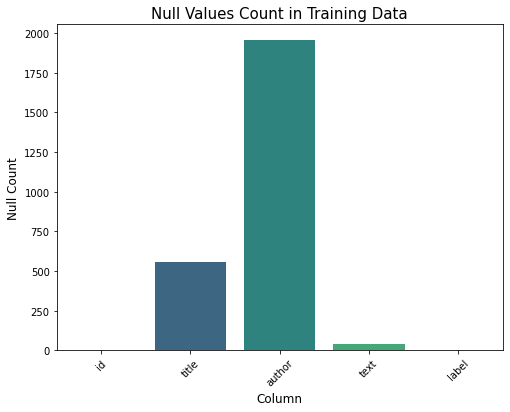

In [131]:
# Create a DataFrame with the null values count
null_values = pd.DataFrame({
    'Column': ['id', 'title', 'author', 'text', 'label'],
    'Null Count': [0, 558, 1957, 39, 0]
})

# Create a count plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Column', y='Null Count', data=null_values, palette='viridis')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Null Count', fontsize=12)
plt.title('Null Values Count in Training Data', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [132]:
# Checking the null values in testing data.
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

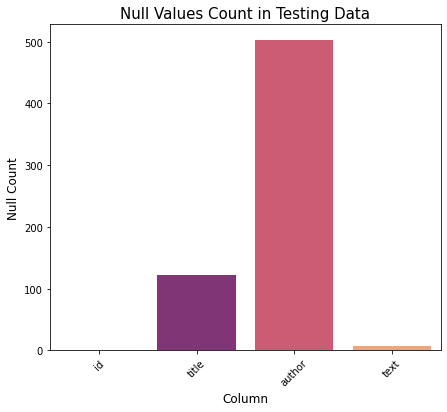

In [133]:
# Create a DataFrame with the null values count
null_values = pd.DataFrame({
    'Column': ['id', 'title', 'author', 'text'],
    'Null Count': [0, 122, 503, 7]
})

# Create a count plot
plt.figure(figsize=(7, 6))
sns.barplot(x='Column', y='Null Count', data=null_values, palette='magma')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Null Count', fontsize=12)
plt.title('Null Values Count in Testing Data', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [134]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [135]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

In [136]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [137]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [138]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [139]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [140]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [141]:
one_hot_train[1]

[3217, 974, 2426, 2491, 4025, 749, 3561, 2984, 1778, 3217]

In [142]:
one_hot_test[1]

[3960, 202, 2204, 1127, 4345, 96, 3814]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [143]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)

In [144]:
print(embedd_docs_train)

[[   0    0    0 ... 2930 1238 4899]
 [   0    0    0 ... 2984 1778 3217]
 [   0    0    0 ... 2818 4770 1642]
 ...
 [   0    0    0 ... 3795 4735 3814]
 [   0    0    0 ... 4989   97  244]
 [   0    0    0 ... 2629  776 2075]]


In [145]:
print(embedd_docs_test)

[[   0    0    0 ... 4651  776  438]
 [   0    0    0 ... 4345   96 3814]
 [   0    0    0 ... 3668 3785 1302]
 ...
 [   0    0    0 ... 4651 4516 2526]
 [   0    0    0 ... 3960   54 1516]
 [   0    0    0 ... 4651 3042 4238]]


In [146]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

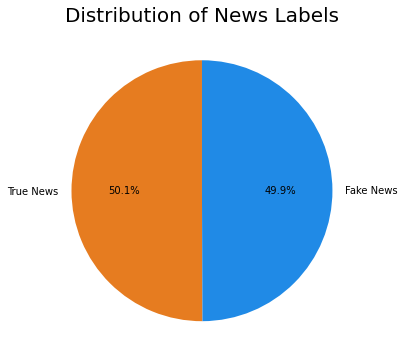

In [147]:
# Assuming y_final contains the labels (1 for True News, 0 for Fake News)
y_labels = ["True News", "Fake News"]
label_counts = [sum(y_final == 1), sum(y_final == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=y_labels, autopct='%1.1f%%', startangle=90, colors=['#e67c20', '#208ae6'])
plt.title("Distribution of News Labels",size="20")
plt.show()

In [148]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [149]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

**1. Logistic Regresssion**


[[807 232]
 [293 748]]


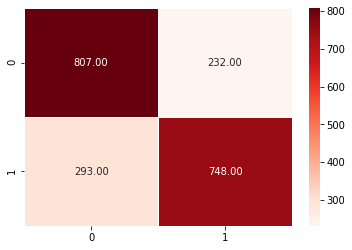

,precision,recall,f1-score,support
0,0.733636,0.776708,0.754558,1039.000000
1,0.763265,0.718540,0.740228,1041.000000
accuracy,0.747596,0.747596,0.747596,0.747596
macro avg,0.748451,0.747624,0.747393,2080.000000
weighted avg,0.748465,0.747596,0.747386,2080.000000


In [150]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
print(f'\n{confusion_matrix(y_test,pred_1)}')
matrix=confusion_matrix(y_test,pred_1)
sns.heatmap(matrix,annot=True,cmap='Reds',fmt='.2f',linewidths=1)
plt.show()
cr1    = classification_report(y_test,pred_1,output_dict=True)
print('\n')
# Convert the classification report to a Pandas DataFrame
df_classification_report = pd.DataFrame(cr1).transpose()

# Add grid lines to the DataFrame
df_classification_report_styled = df_classification_report.style.set_properties(**{'border': '1px solid black'})

# Display the DataFrame with grid lines
df_classification_report_styled


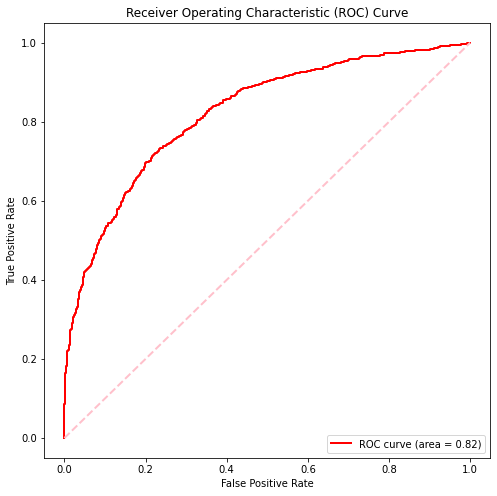

In [162]:
# Get predicted probabilities for the positive class (class 1)
probas_1 = model_1.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probas_1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**2. Naive Bayes**


[[598 441]
 [267 774]]


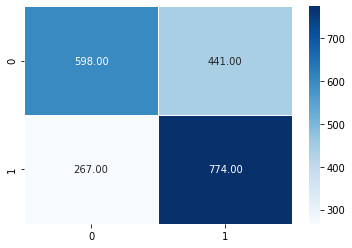

,precision,recall,f1-score,support
0,0.691329,0.575553,0.628151,1039.000000
1,0.637037,0.743516,0.686170,1041.000000
accuracy,0.659615,0.659615,0.659615,0.659615
macro avg,0.664183,0.659535,0.657161,2080.000000
weighted avg,0.664157,0.659615,0.657189,2080.000000


In [151]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
print(f'\n{confusion_matrix(y_test,pred_2)}')
matrix=confusion_matrix(y_test,pred_2)
sns.heatmap(matrix,annot=True,cmap='Blues',fmt='.2f',linewidths=1)
plt.show()
cr2    = classification_report(y_test,pred_2,output_dict=True)
print('\n')
# Convert the classification report to a Pandas DataFrame
df_classification_report = pd.DataFrame(cr2).transpose()

# Add grid lines to the DataFrame
df_classification_report_styled = df_classification_report.style.set_properties(**{'border': '1px solid black'})

# Display the DataFrame with grid lines
df_classification_report_styled


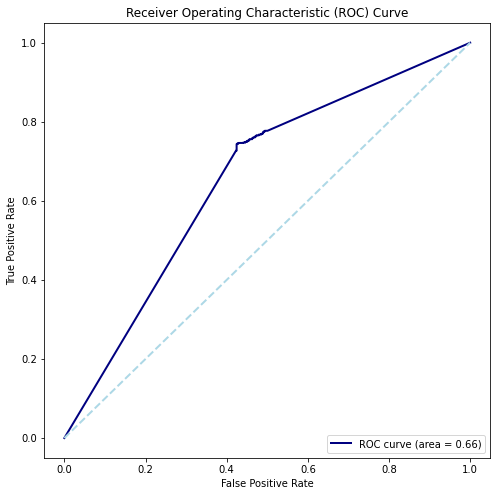

In [161]:
# Get predicted probabilities for the positive class (class 1)
probas_2 = model_2.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probas_2)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**3. Decision Trees**


[[942  97]
 [101 940]]


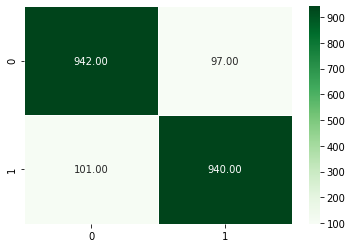

,precision,recall,f1-score,support
0,0.903164,0.906641,0.904899,1039.000000
1,0.906461,0.902978,0.904716,1041.000000
accuracy,0.904808,0.904808,0.904808,0.904808
macro avg,0.904812,0.904809,0.904808,2080.000000
weighted avg,0.904814,0.904808,0.904808,2080.000000


In [152]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
print(f'\n{confusion_matrix(y_test,pred_3)}')
matrix=confusion_matrix(y_test,pred_3)
sns.heatmap(matrix,annot=True,cmap='Greens',fmt='.2f',linewidths=1)
plt.show()
cr3    = classification_report(y_test,pred_3,output_dict=True)
print('\n')
# Convert the classification report to a Pandas DataFrame
df_classification_report = pd.DataFrame(cr3).transpose()

# Add grid lines to the DataFrame
df_classification_report_styled = df_classification_report.style.set_properties(**{'border': '1px solid black'})

# Display the DataFrame with grid lines
df_classification_report_styled


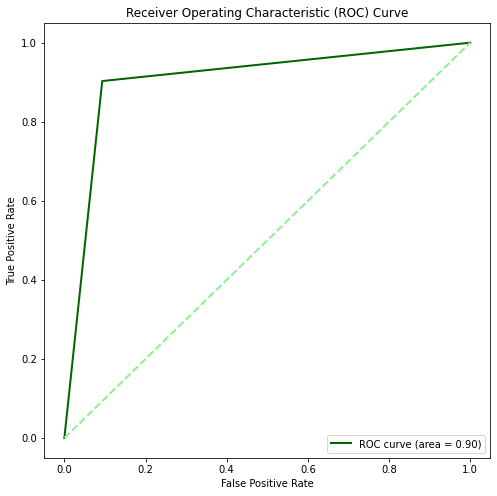

In [164]:
# Get predicted probabilities for the positive class (class 1)
probas_3 = model_3.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probas_3)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='lightgreen', lw=2, linestyle='--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**4. Random Forest**


[[ 909  130]
 [  41 1000]]


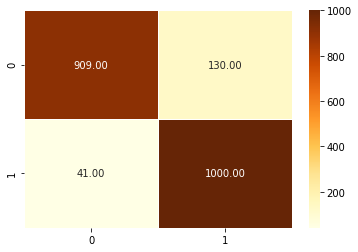

,precision,recall,f1-score,support
0,0.956842,0.874880,0.914027,1039.000000
1,0.884956,0.960615,0.921234,1041.000000
accuracy,0.917788,0.917788,0.917788,0.917788
macro avg,0.920899,0.917747,0.917631,2080.000000
weighted avg,0.920864,0.917788,0.917634,2080.000000


In [153]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
print(f'\n{confusion_matrix(y_test,pred_4)}')
matrix=confusion_matrix(y_test,pred_4)
sns.heatmap(matrix,annot=True,cmap='YlOrBr',fmt='.2f',linewidths=1)
plt.show()
cr4    = classification_report(y_test,pred_4,output_dict=True)
print('\n')
# Convert the classification report to a Pandas DataFrame
df_classification_report = pd.DataFrame(cr4).transpose()

# Add grid lines to the DataFrame
df_classification_report_styled = df_classification_report.style.set_properties(**{'border': '1px solid black'})

# Display the DataFrame with grid lines
df_classification_report_styled


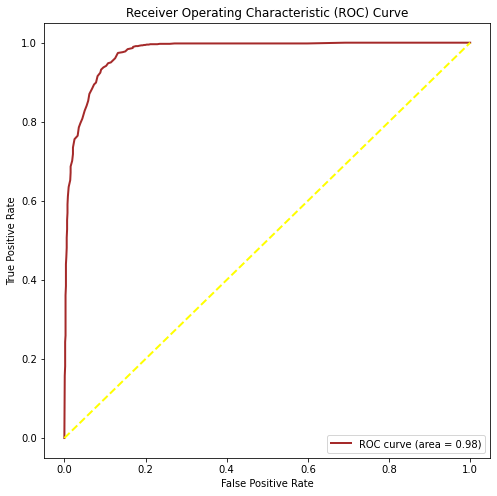

In [166]:
# Get predicted probabilities for the positive class (class 1)
probas_4 = model_4.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probas_4)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='brown', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='yellow', lw=2, linestyle='--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluation of Models

**Tabulating the results of various implemented models.**

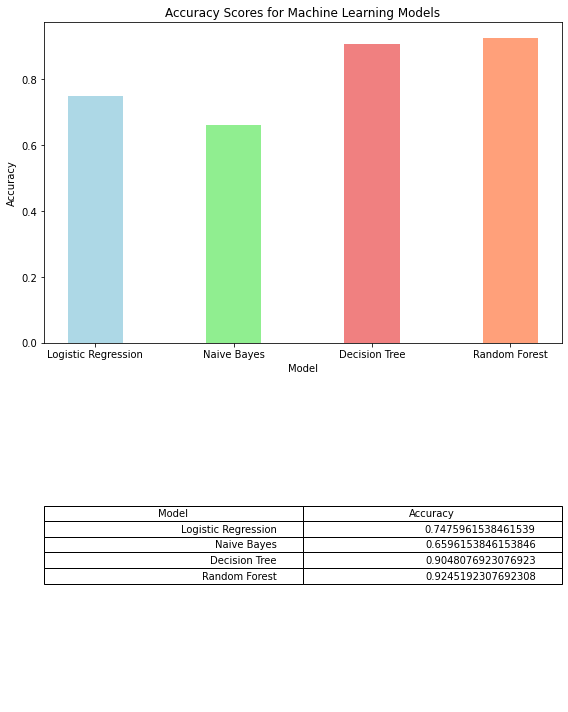

In [154]:
score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,predictions)

# Create a DataFrame with the model names and accuracy scores
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4]],columns=["Model","Accuracy"])

# Create a figure and two sets of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the bar plot in the first subplot
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
ax1.bar(results["Model"], results["Accuracy"], color=colors, width=0.4)
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Scores for Machine Learning Models")

# Create the table in the second subplot
ax2.axis('off')
table = ax2.table(cellText=results.values, colLabels=results.columns, loc='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

**Discussion: From the above results, it appears that Decision Tree
Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.**

**Predictions on Testing Data**

In [155]:
# Making Predictions on test data
predictions_test = (model_3.predict(x_test_final) > 0.5).astype("int32")
test_id = pd.DataFrame(test["id"])
# Convert the NumPy array to a DataFrame
predictions_test_df = pd.DataFrame(predictions_test, columns=["label"])
# Concatenate DataFrames
submission = pd.concat([test_id, predictions_test_df], axis=1)
submission.columns = ["id","label"]
submission.to_csv("Submission.csv",index=False)

In [156]:
submission.head(20)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,1
6,20806,0
7,20807,1
8,20808,1
9,20809,1


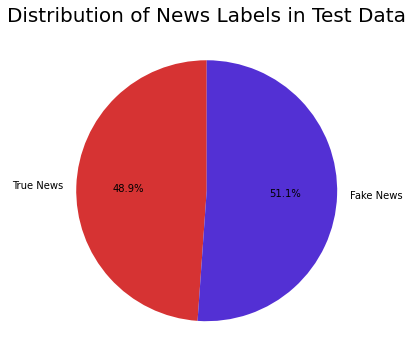

In [177]:
y1 = submission['label']
y_final1 = np.array(y1)
y1_labels = ["True News", "Fake News"]
label_counts = [sum(y_final1 == 1), sum(y_final1 == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=y_labels, autopct='%1.1f%%', startangle=90, colors=['#D63333', '#5330D4'])
plt.title("Distribution of News Labels in Test Data",size="20")
plt.show()